In [ ]:
pip install qiskit qiskit_aer

In [ ]:
pip install tabulate




---

# Imports
---


In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.visualization import *
from numpy import pi
import numpy as np
import math
from qiskit_aer import Aer
from qiskit import transpile
import qiskit.quantum_info as qi
import random
from qiskit.circuit.library import SdgGate
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from tabulate import tabulate
from tqdm import tqdm
import time
import CEC
import QL
import CL
import QuditObj



---

# 2-Dimension QKD functions

---



In [ ]:
def TwoD_BB84(BitSequence,AliceBases,BobBases,EveBases,length,Eve,theta_radians,QChannel):
   SNR = 15.29
   EP = 0.07
   Base = 1
   if QChannel:
    RAliceBases = SendQuantumOAMChannel(AliceBases,EP,Base,True)
   else:
    RAliceBases = SendClassicalChannel(AliceBases,SNR,4,True)
   ListOfCounts = []
   EveListOfCounts = []
   if Eve==True:
    for i in range(length):
        Qubit = QuantumCircuit(1,1)
        #Getting that one photon with Alice's Basis ready to send
        Qubit = QL.POL_Modulation(Qubit,BitSequence[i],AliceBases[i],2*theta_radians)
        #Recive Single Photon
        counts = QL.POL_ReciviengSinglePhoton(Qubit,EveBases[i],Shots = 1)
        #Measure one Photon with Bob Basis
        EveListOfCounts.append(counts)
        del Qubit
    output_string = QL.POL_Getbits(EveListOfCounts)
    list_from_Key = [int(char) for char in output_string]
    ListOfCounts = []
    for i in range(length):
        Qubit = QuantumCircuit(1,1)
        #Getting that one photon with Alice's Basis ready to send
        Qubit = QL.POL_Modulation(Qubit,BitSequence[i],EveBases[i],2*theta_radians)
        #Recive Single Photon
        counts = QL.POL_ReciviengSinglePhoton(Qubit,BobBases[i],Shots = 1)
        #Measure one Photon with Bob Basis
        ListOfCounts.append(counts)
        del Qubit
    Check_list = []
    EveCheck_list = []
    for i in range(len(AliceBases)):
        if RAliceBases[i] == BobBases[i]:
            Check_list.append(ListOfCounts[i])
            EveCheck_list.append(EveListOfCounts[i])
    #print("The Bases checked list is : ",Check_list)
    output_string= QL.POL_Getbits(Check_list)
    Eveoutput_string= QL.POL_Getbits(EveCheck_list)
    return  output_string , Eveoutput_string
   else:
    for i in range(length):
        Qubit = QuantumCircuit(1,1)
        #Getting that one photon with Alice's Basis ready to send
        Qubit = QL.POL_Modulation(Qubit,BitSequence[i],AliceBases[i],2*theta_radians)
        #Recive Single Photon
        counts = QL.POL_ReciviengSinglePhoton(Qubit,BobBases[i],Shots = 1)
        #Measure one Photon with Bob Basis
        ListOfCounts.append(counts)
        del Qubit
    #Now Alice and Bob share their Bases
    #print("Raw List of count is : ",ListOfCounts)
    Check_list = []
    for i in range(len(AliceBases)):
        if RAliceBases[i] == BobBases[i]:
            Check_list.append(ListOfCounts[i])
    #print("The Bases checked list is : ",Check_list)
    output_string= QL.POL_Getbits(Check_list)
    return  output_string




---

# 4-Dimension QKD functions

---



In [ ]:
def FourD_BB84(BitSequence,AliceBases,BobBases,EveBases,length,Eve,CrossT,QChannel):
   SNR = 15.29
   EP = 0.07
   Base = 1
   if QChannel:
    RAliceBases = SendQuantumOAMChannel(AliceBases,EP,Base,True)
   else:
    RAliceBases = SendClassicalChannel(AliceBases,SNR,4,True)
   EP = 0.11
   DitSequence = map_bits_to_numbers(BitSequence)
   #print(DitSequence)
   length2 = len(DitSequence)
   EveListOfCounts = []
   if Eve==True:
    for i in range(length2):
        #print("for bit number : ", i)
        Qudit = QuditObj.QuditCircuit(4,1)
        #Getting that one photon with Alice's Basis ready to send
        Qudit = QL.OAM_Modulation(Qudit,DitSequence[i],AliceBases[i])
        #circuit = GettingReady(circuit,BitSequence[i],AliceBases[i])
        #Sending Single photon
        QL.OAM_CrossTalk(Qudit,EP) if CrossT else None
        #Recive Single Photon
        QL.OAM_ReciviengSinglePhoton(Qudit,EveBases[i],Shot=1)
        #Measure one Photon with Bob Basis
        EveListOfCounts.append(Qudit.Counts2)
    output_string = QL.OAM_Getdits(EveListOfCounts)
    list_from_Key = [int(char) for char in output_string]
    ListOfCounts = []
    for i in range(length2):
        #print("for bit number : ", i)
        Qudit = QuditObj.QuditCircuit(4,1)
        #Getting that one photon with Alice's Basis ready to send
        Qudit = QL.OAM_Modulation(Qudit,DitSequence[i],EveBases[i])
        #circuit = GettingReady(circuit,BitSequence[i],AliceBases[i])
        #Sending Single photon
        QL.OAM_CrossTalk(Qudit,EP) if CrossT else None
        #Recive Single Photon
        QL.OAM_ReciviengSinglePhoton(Qudit,BobBases[i],Shot=1)
        #Measure one Photon with Bob Basis
        ListOfCounts.append(Qudit.Counts2)
    countstring = QL.OAM_Getdits(ListOfCounts)
    countbit = map_numbers_to_bits(countstring,length)
    countlist = [int(char) for char in countbit]
    Evecountstring = QL.OAM_Getdits(EveListOfCounts)
    Evecountbit = map_numbers_to_bits(Evecountstring,length)
    Evecountlist = [int(char) for char in Evecountbit]
    Check_list = []
    EveCheck_list = []
    for i in range(len(AliceBases)):
       if RAliceBases[i] == BobBases[i]:
           Check_list.append(countlist[2*i])
           Check_list.append(countlist[(2*i)+1])
           EveCheck_list.append(Evecountlist[2*i])
           EveCheck_list.append(Evecountlist[(2*i)+1])
    #print("The Bases checked list is : ",Check_list)
    output_string = ''.join(str(bit) for bit in Check_list)
    Eveoutput_string = ''.join(str(bit) for bit in EveCheck_list)
    return output_string , Eveoutput_string
   else:
    ListOfCounts = []
    for i in range(length2):
        #print("for bit number : ", i)
        Qudit = QuditObj.QuditCircuit(4,1)
        #Getting that one photon with Alice's Basis ready to send
        Qudit = QL.OAM_Modulation(Qudit,DitSequence[i],AliceBases[i])
        #circuit = GettingReady(circuit,BitSequence[i],AliceBases[i])
        #Sending Single photon
        QL.OAM_CrossTalk(Qudit,EP) if CrossT else None
        #Recive Single Photon
        QL.OAM_ReciviengSinglePhoton(Qudit,BobBases[i],Shot=1)
        #Measure one Photon with Bob Basis
        #print("Dit is : ",DitSequence[i]," Alice : ",AliceBases[i]," Bob : ", BobBases[i]," Measuered : ",Qudit.Counts2)

        ListOfCounts.append(Qudit.Counts2)
    countstring = QL.OAM_Getdits(ListOfCounts)
    #print(countstring)
    countbit = map_numbers_to_bits(countstring,length)
    #print(countbit)
    countlist = [int(char) for char in countbit]
    #print(countlist)
    Check_list = []
    #count = 0
    for i in range(len(AliceBases)):
       if RAliceBases[i] == BobBases[i]:
           Check_list.append(countlist[2*i])
           Check_list.append(countlist[(2*i)+1])
           #count += 1
    #print("The Bases checked list is : ",Check_list)

    output_string = ''.join(str(bit) for bit in Check_list)
    #print(count)
    return output_string





---

# Other functions

---



In [ ]:
def AliceKeyGenerator(Dim,Bit,AliceBases,BobBases):
    if Dim > 2 :
      Dit = map_bits_to_numbers(Bit)
    Check_list = []
    length = len(Dit) if Dim > 2  else len(Bit)

    for i in range(length):
        if AliceBases[i] == BobBases[i]:
            appendble = Dit[i] if Dim > 2 else Bit[i]
            Check_list.append(appendble)
        Key = ''
    for item in Check_list:
        Key = Key + str(item)
    if Dim > 2:
      Key = map_numbers_to_bits(Key,len(Bit))
    return Key
def CheckSecurity(Key,Akey,Checklength):
    if Akey[-Checklength:] == Key[-Checklength:]:
        print("The Connection is Secure with the probability of:")
        print((1-((3/4)**Checklength))*100)
    else:
        print("The Connection is not Secure!")
def calculate_error_percentage(string1, string2):
    # Check if both strings are of the same length
    if len(string1) != len(string2):
        return '*'

    # Count the number of mismatched bits
    errors = sum(bit1 != bit2 for bit1, bit2 in zip(string1, string2))

    # Calculate the error percentage
    total_bits = len(string1)
    error_percentage = (errors / total_bits) * 100

    return error_percentage
def map_bits_to_numbers(bit_list):
    # Work on a copy of the input list to avoid modifying the original list
    modified_bit_list = bit_list.copy()
    # Ensure the list length is even by appending a 0 if necessary
    if len(modified_bit_list) % 2 != 0:
        modified_bit_list.append(0)

    # Map pairs of bits to numbers
    number_list = []
    for i in range(0, len(modified_bit_list), 2):
        pair = modified_bit_list[i:i+2]
        number = pair[0] * 2 + pair[1]
        number_list.append(number)
    return number_list # Return the original length as well

def map_numbers_to_bits(number_string, original_length):
    bit_string = ""
    for char in number_string:
        num = int(char)
        bits = f"{num:02b}"  # Convert number to its 2-bit binary representation
        bit_string += bits

    # If the original bit list length was odd, remove the last bit

    if original_length % 2 != 0:
        bit_string = bit_string[:-1]

    return bit_string
def generate_random_sequence(length):
    return [random.randint(0, 1) for _ in range(length)]
def statistic_calculator(results,ave):
  count_stars = 0
  filtered_list = []

  for item in results:
      if item == '*':
          count_stars += 1
      else:
          filtered_list.append(item)
  sum = 0
  NDetection = 0
  for Err in filtered_list:
    sum += Err
    if Err > ave:
      NDetection += 1
  ma = max(filtered_list)
  mi = min(filtered_list)
  return ma , mi, sum/len(filtered_list), count_stars, (NDetection*100)/len(filtered_list)

In [ ]:
def RunningQKD(Dimension,BitSequence,AliceBases,BobBases,EveBases,length,Eve,Error):
  QC = False
  Evekey="0"
  if Dimension == 2:
    if Error:
      if Eve :
        Bobkey,Evekey = TwoD_BB84(BitSequence,AliceBases,BobBases,EveBases,length,Eve,np.radians(25.84193276),QC)
      else:
        Bobkey = TwoD_BB84(BitSequence,AliceBases,BobBases,EveBases,length,Eve,np.radians(25.84193276),QC)
    else:
      if Eve:
        Bobkey,Evekey = TwoD_BB84(BitSequence,AliceBases,BobBases,EveBases,length,Eve,0,QC)
      else:
        Bobkey = TwoD_BB84(BitSequence,AliceBases,BobBases,EveBases,length,Eve,0,QC)
  if Dimension == 4:
    if Error:
      if Eve:
        Bobkey,Evekey = FourD_BB84(BitSequence,AliceBases,BobBases,EveBases,length,Eve,True,QC)
      else:
        Bobkey = FourD_BB84(BitSequence,AliceBases,BobBases,EveBases,length,Eve,True,QC)
    else:
      if Eve:
        Bobkey,Evekey = FourD_BB84(BitSequence,AliceBases,BobBases,EveBases,length,Eve,False,QC)
      else:
        Bobkey = FourD_BB84(BitSequence,AliceBases,BobBases,EveBases,length,Eve,False,QC)
  return Bobkey,Evekey
def SendClassicalChannel(SendingList,SNR,M,EC):
  length = len(SendingList)
  if EC :
     Parity_added = CEC.add_parity_bits(convert_to_np_array(SendingList),length)
  else:
     Parity_added = convert_to_np_array(SendingList)
  Encoded_SendingData = CL.encode_MPSK(Parity_added,M)
  Noisy_Encoded_SendigData = CL.add_awgn_noise(Encoded_SendingData,SNR)
  Decided_Symbols = CL.decision_maker(Noisy_Encoded_SendigData,M)
  Received_SendingData = CL.decode_MPSK(Decided_Symbols,M)
  if EC:
    RData = convert_from_np_array(CEC.EC_with_parity(Received_SendingData,length)[:length],False)
  else:
    RData = convert_from_np_array(Received_SendingData,False)
  return RData
def SendQuantumOAMChannel(SendingList,EP,Base,EC):
  length = len(SendingList)
  if EC :
      Parity_added = convert_from_np_array(CEC.add_parity_bits(convert_to_np_array(SendingList),length),False)
  else:
      Parity_added = SendingList
  DitSequence = map_bits_to_numbers(Parity_added)
  length2 = len(Parity_added)
  ListofCounts = []
  for dit in DitSequence:
    Qudit = QuditObj.QuditCircuit(4,1)
    Qudit = QL.OAM_Modulation(Qudit,dit,Base)
    QL.OAM_CrossTalk(Qudit,EP)
    QL.OAM_ReciviengSinglePhoton(Qudit,Base,Shot=1)
    ListofCounts.append(Qudit.Counts2)
  RDits = QL.OAM_Getdits(ListofCounts)
  RBits = map_numbers_to_bits(RDits,length2)
  if EC:
    CorrectedBits = convert_from_np_array(CEC.EC_with_parity(convert_to_np_array(RBits),length)[:length],False)
  else:
    CorrectedBits = RBits
    CorrectedBits = [int(num) for num in CorrectedBits]
  return CorrectedBits



In [ ]:
def convert_to_np_array(data):
    """
    Converts a list or string of numbers into a numpy array of integers.

    Parameters:
    data (list or str): Input list or string of numbers.

    Returns:
    np.ndarray: Numpy array of integers from the input data.
    """
    if isinstance(data, str):
        data = [int(num) for num in data]
    elif isinstance(data, list):
        data = np.array(data, dtype=int)
    else:
        raise ValueError("Input must be a list or a string of numbers")
    return np.array(data, dtype=int)

def convert_from_np_array(np_array, to_string):
    """
    Converts a numpy array into a list or a string.

    Parameters:
    np_array (np.ndarray): Input numpy array.
    to_string (bool): If True, convert to string; if False, convert to list.

    Returns:
    list or str: Converted list or string from the numpy array.
    """
    if not isinstance(np_array, np.ndarray):
        raise ValueError("Input must be a numpy array")

    if to_string:
        return ''.join(map(str, np_array))
    else:
        return np_array.tolist()




---

# Running the Simulation

---


In [ ]:
length=32
TwoD_NEve_NE_List = []
TwoD_WEve_NE_AB_List = []
TwoD_WEve_NE_Eve_List = []
TwoD_NEve_WE_List = []
TwoD_WEve_WE_AB_List = []
TwoD_WEve_WE_Eve_List = []
FourD_NEve_NE_List = []
FourD_WEve_NE_AB_List = []
FourD_WEve_NE_Eve_List = []
FourD_NEve_WE_List = []
FourD_WEve_WE_AB_List = []
FourD_WEve_WE_Eve_List = []
N = 300
for i in  tqdm(range(N), desc="Processing"):
  BitSequence= generate_random_sequence(length)
  AliceBases = generate_random_sequence(length)
  BobBases = generate_random_sequence(length)
  EveBases = generate_random_sequence(length)
  Alicekey = AliceKeyGenerator(2,BitSequence,AliceBases,BobBases)
  FAliceBases = generate_random_sequence(int(length/2))
  FBobBases = generate_random_sequence(int(length/2))
  FEveBases = generate_random_sequence(int(length/2))
  FAlicekey = AliceKeyGenerator(4,BitSequence,FAliceBases,FBobBases)
  TwoD_Bobkey_NEve_NE, TwoD_Evekey_NEve_NE = RunningQKD(2,BitSequence,AliceBases,BobBases,EveBases,length,False,False)
  TwoD_Bobkey_WEve_NE, TwoD_Evekey_WEve_NE = RunningQKD(2,BitSequence,AliceBases,BobBases,EveBases,length,True,False)
  TwoD_Bobkey_NEve_WE, TwoD_Evekey_NEve_WE = RunningQKD(2,BitSequence,AliceBases,BobBases,EveBases,length,False,True)
  TwoD_Bobkey_WEve_WE, TwoD_Evekey_WEve_WE = RunningQKD(2,BitSequence,AliceBases,BobBases,EveBases,length,True,True)
  FourD_Bobkey_NEve_NE, FourD_Evekey_NEve_NE = RunningQKD(4,BitSequence,FAliceBases,FBobBases,FEveBases,length,False,False)
  FourD_Bobkey_WEve_NE, FourD_Evekey_WEve_NE = RunningQKD(4,BitSequence,FAliceBases,FBobBases,FEveBases,length,True,False)
  FourD_Bobkey_NEve_WE, FourD_Evekey_NEve_WE = RunningQKD(4,BitSequence,FAliceBases,FBobBases,FEveBases,length,False,True)
  FourD_Bobkey_WEve_WE, FourD_Evekey_WEve_WE = RunningQKD(4,BitSequence,FAliceBases,FBobBases,FEveBases,length,True,True)
  TwoD_NEve_NE = calculate_error_percentage(TwoD_Bobkey_NEve_NE,Alicekey)
  TwoD_WEve_NE_AB = calculate_error_percentage(TwoD_Bobkey_WEve_NE,Alicekey)
  TwoD_WEve_NE_Eve = calculate_error_percentage(TwoD_Evekey_WEve_NE,Alicekey)
  TwoD_NEve_WE = calculate_error_percentage(TwoD_Bobkey_NEve_WE,Alicekey)
  TwoD_WEve_WE_AB = calculate_error_percentage(TwoD_Bobkey_WEve_WE,Alicekey)
  TwoD_WEve_WE_Eve = calculate_error_percentage(TwoD_Evekey_WEve_WE,Alicekey)
  FourD_NEve_NE = calculate_error_percentage(FourD_Bobkey_NEve_NE,FAlicekey)
  FourD_WEve_NE_AB = calculate_error_percentage(FourD_Bobkey_WEve_NE,FAlicekey)
  FourD_WEve_NE_Eve = calculate_error_percentage(FourD_Evekey_WEve_NE,FAlicekey)
  FourD_NEve_WE = calculate_error_percentage(FourD_Bobkey_NEve_WE,FAlicekey)
  FourD_WEve_WE_AB = calculate_error_percentage(FourD_Bobkey_WEve_WE,FAlicekey)
  FourD_WEve_WE_Eve = calculate_error_percentage(FourD_Evekey_WEve_WE,FAlicekey)
  TwoD_NEve_NE_List.append(TwoD_NEve_NE)
  TwoD_WEve_NE_AB_List.append(TwoD_WEve_NE_AB)
  TwoD_WEve_NE_Eve_List.append(TwoD_WEve_NE_Eve)
  TwoD_NEve_WE_List.append(TwoD_NEve_WE)
  TwoD_WEve_WE_AB_List.append(TwoD_WEve_WE_AB)
  TwoD_WEve_WE_Eve_List.append(TwoD_WEve_WE_Eve)
  FourD_NEve_NE_List.append(FourD_NEve_NE)
  FourD_WEve_NE_AB_List.append(FourD_WEve_NE_AB)
  FourD_WEve_NE_Eve_List.append(FourD_WEve_NE_Eve)
  FourD_NEve_WE_List.append(FourD_NEve_WE)
  FourD_WEve_WE_AB_List.append(FourD_WEve_WE_AB)
  FourD_WEve_WE_Eve_List.append(FourD_WEve_WE_Eve)




Processing: 100%|██████████| 300/300 [28:45<00:00,  5.75s/it]




---

## BB84 with Quantum Channel

---
With a Error Probability of 7%


In [ ]:
av2 = 11.0
av4 = 4.0


In [ ]:
headers = ["Description", "Max Error Rate (%)", "Min Error Rate (%)", "Average Error Rate (%)", "Number of Abortions","Precent of Detection(%)"]

data = [
    ["Two Dimension No Eve No Error Bob's Key"] + list(statistic_calculator(TwoD_NEve_NE_List,av2)),
    ["Two Dimension No Eve With Error Bob's Key"] + list(statistic_calculator(TwoD_NEve_WE_List,av2)),
    ["Two Dimension With Eve No Error Bob's Key"] + list(statistic_calculator(TwoD_WEve_NE_AB_List,av2)),
    ["Two Dimension With Eve No Error Eve's Key"] + list(statistic_calculator(TwoD_WEve_NE_Eve_List,100)),
    ["Two Dimension With Eve With Error Bob's Key"] + list(statistic_calculator(TwoD_WEve_WE_AB_List,av2)),
    ["Two Dimension With Eve With Error Eve's Key"] + list(statistic_calculator(TwoD_WEve_WE_Eve_List,100)),
    ["Four Dimension No Eve No Error Bob's Key"] + list(statistic_calculator(FourD_NEve_NE_List,av4)),
    ["Four Dimension No Eve With Error Bob's Key"] + list(statistic_calculator(FourD_NEve_WE_List,av4)),
    ["Four Dimension With Eve No Error Bob's Key"] + list(statistic_calculator(FourD_WEve_NE_AB_List,av4)),
    ["Four Dimension With Eve No Error Eve's Key"] + list(statistic_calculator(FourD_WEve_NE_Eve_List,100)),
    ["Four Dimension With Eve With Error Bob's Key"] + list(statistic_calculator(FourD_WEve_WE_AB_List,av4)),
    ["Four Dimension With Eve With Error Eve's Key"] + list(statistic_calculator(FourD_WEve_WE_Eve_List,100)),
]

print(tabulate(data, headers=headers, tablefmt="grid"))


+----------------------------------------------+----------------------+----------------------+--------------------------+-----------------------+---------------------------+
| Description                                  |   Max Error Rate (%) |   Min Error Rate (%) |   Average Error Rate (%) |   Number of Abortions |   Precent of Detection(%) |
+==============================================+======================+======================+==========================+=======================+===========================+
| Two Dimension No Eve No Error Bob's Key      |              50      |              0       |                 0.829466 |                    24 |                  3.26087  |
+----------------------------------------------+----------------------+----------------------+--------------------------+-----------------------+---------------------------+
| Two Dimension No Eve With Error Bob's Key    |              46.1538 |              0       |                19.3292   |         



---

## BB84 with Classical Channel

---
With a SNR of 15.28 dB


In [ ]:
headers = ["Description", "Max Error Rate (%)", "Min Error Rate (%)", "Average Error Rate (%)", "Number of Abortions","Precent of Detection(%)"]

data = [
    ["Two Dimension No Eve No Error Bob's Key"] + list(statistic_calculator(TwoD_NEve_NE_List,av2)),
    ["Two Dimension No Eve With Error Bob's Key"] + list(statistic_calculator(TwoD_NEve_WE_List,av2)),
    ["Two Dimension With Eve No Error Bob's Key"] + list(statistic_calculator(TwoD_WEve_NE_AB_List,av2)),
    ["Two Dimension With Eve No Error Eve's Key"] + list(statistic_calculator(TwoD_WEve_NE_Eve_List,100)),
    ["Two Dimension With Eve With Error Bob's Key"] + list(statistic_calculator(TwoD_WEve_WE_AB_List,av2)),
    ["Two Dimension With Eve With Error Eve's Key"] + list(statistic_calculator(TwoD_WEve_WE_Eve_List,100)),
    ["Four Dimension No Eve No Error Bob's Key"] + list(statistic_calculator(FourD_NEve_NE_List,av4)),
    ["Four Dimension No Eve With Error Bob's Key"] + list(statistic_calculator(FourD_NEve_WE_List,av4)),
    ["Four Dimension With Eve No Error Bob's Key"] + list(statistic_calculator(FourD_WEve_NE_AB_List,av4)),
    ["Four Dimension With Eve No Error Eve's Key"] + list(statistic_calculator(FourD_WEve_NE_Eve_List,100)),
    ["Four Dimension With Eve With Error Bob's Key"] + list(statistic_calculator(FourD_WEve_WE_AB_List,av4)),
    ["Four Dimension With Eve With Error Eve's Key"] + list(statistic_calculator(FourD_WEve_WE_Eve_List,100)),
]

print(tabulate(data, headers=headers, tablefmt="grid"))

+----------------------------------------------+----------------------+----------------------+--------------------------+-----------------------+---------------------------+
| Description                                  |   Max Error Rate (%) |   Min Error Rate (%) |   Average Error Rate (%) |   Number of Abortions |   Precent of Detection(%) |
+==============================================+======================+======================+==========================+=======================+===========================+
| Two Dimension No Eve No Error Bob's Key      |              33.3333 |              0       |                 0.530507 |                    27 |                   1.8315  |
+----------------------------------------------+----------------------+----------------------+--------------------------+-----------------------+---------------------------+
| Two Dimension No Eve With Error Bob's Key    |              50      |              0       |                19.0827   |         



---

## Channel Characterizations

---
Quantum Channel(without error correction and OAM Base)

In [ ]:
ep_values = np.arange(0.00, 0.5, 0.005)
EC = False
Base = 0
length = 32
error_percentages = []
for EP in ep_values:
    SendingList = generate_random_sequence(length)
    mean = 0.0
    for i in range(10):
      ReceivedList = SendQuantumOAMChannel(SendingList, EP, Base, EC)
      ReceivedString = ''.join(str(bit) for bit in ReceivedList)
      SendingString = ''.join(str(bit) for bit in SendingList)
      error_percentage = calculate_error_percentage(ReceivedString, SendingString)
      mean += error_percentage
    error_percentages.append(mean/10)
EC = True
Base = 0
length = 32
error_percentagesEC = []
for EP in ep_values:
    SendingList = generate_random_sequence(length)
    mean = 0.0
    for i in range(10):
      ReceivedList = SendQuantumOAMChannel(SendingList, EP, Base, EC)
      ReceivedString = ''.join(str(bit) for bit in ReceivedList)
      SendingString = ''.join(str(bit) for bit in SendingList)
      error_percentage = calculate_error_percentage(ReceivedString, SendingString)
      mean += error_percentage
    error_percentagesEC.append(mean/10)
EC = False
Base = 1
length = 32
ANGerror_percentages = []
for EP in ep_values:
    SendingList = generate_random_sequence(length)
    mean = 0.0
    for i in range(10):
      ReceivedList = SendQuantumOAMChannel(SendingList, EP, Base, EC)
      ReceivedString = ''.join(str(bit) for bit in ReceivedList)
      SendingString = ''.join(str(bit) for bit in SendingList)
      error_percentage = calculate_error_percentage(ReceivedString, SendingString)
      mean += error_percentage
    ANGerror_percentages.append(mean/10)
EC = True
Base = 1
length = 32
ANGerror_percentagesEC = []
for EP in ep_values:
    SendingList = generate_random_sequence(length)
    mean = 0.0
    for i in range(10):
      ReceivedList = SendQuantumOAMChannel(SendingList, EP, Base, EC)
      ReceivedString = ''.join(str(bit) for bit in ReceivedList)
      SendingString = ''.join(str(bit) for bit in SendingList)
      error_percentage = calculate_error_percentage(ReceivedString, SendingString)
      mean += error_percentage
    ANGerror_percentagesEC.append(mean/10)

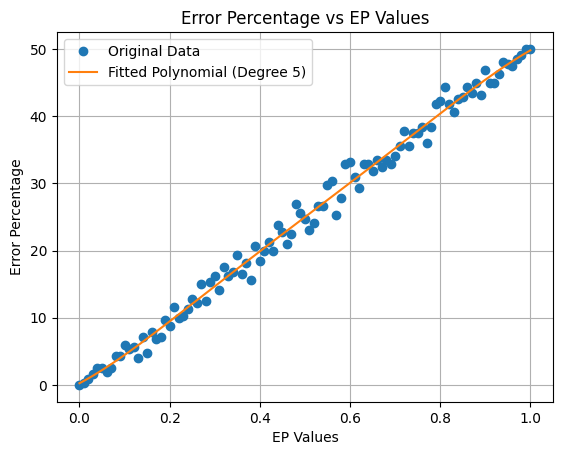

In [ ]:
# Fit a polynomial of degree 2 (quadratic) to the data
degree = 5
coefficients = np.polyfit(ep_values, error_percentages, degree)

# Create a polynomial function from the coefficients
polynomial_function = np.poly1d(coefficients)

# Generate new x values for a smooth curve
ep_values_smooth = np.linspace(min(ep_values), max(ep_values), 500)

# Use the polynomial function to get the corresponding y values
error_percentages_smooth = polynomial_function(ep_values_smooth)

# Plot the original data points
plt.plot(ep_values, error_percentages, 'o', label='Original Data')

# Plot the fitted polynomial curve
plt.plot(ep_values_smooth, error_percentages_smooth, '-', label=f'Fitted Polynomial (Degree {degree})')

plt.xlabel('EP Values')
plt.ylabel('Error Percentage')
plt.title('Error Percentage vs EP Values')
plt.legend()
plt.grid(True)
plt.show()

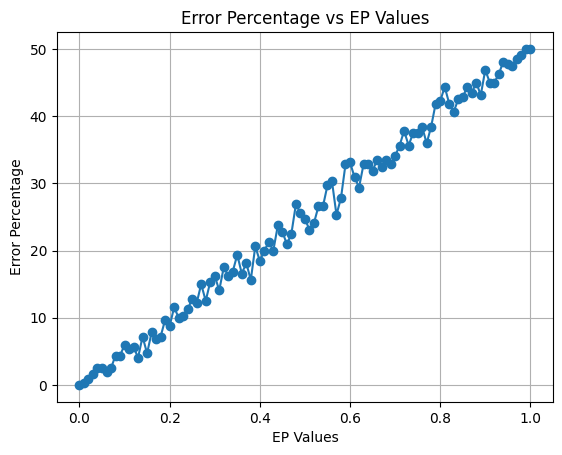

In [ ]:
# Plot the Error Percentage for each EP value
plt.plot(ep_values, error_percentages, marker='o')
plt.xlabel('EP Values')
plt.ylabel('Error Percentage')
plt.title('Error Percentage vs EP Values')
plt.grid(True)
plt.show()




---

## Channel Characterizations

---
Quantum Channel(with error correction and OAM Base)

In [ ]:
EC = True
Base = 0
length = 32
error_percentagesEC = []
for EP in ep_values:
    SendingList = generate_random_sequence(length)
    mean = 0.0
    for i in range(10):
      ReceivedList = SendQuantumOAMChannel(SendingList, EP, Base, EC)
      ReceivedString = ''.join(str(bit) for bit in ReceivedList)
      SendingString = ''.join(str(bit) for bit in SendingList)
      error_percentage = calculate_error_percentage(ReceivedString, SendingString)
      mean += error_percentage
    error_percentagesEC.append(mean/10)

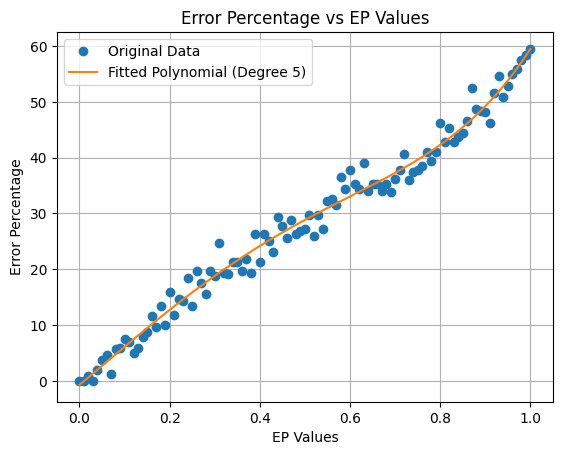

In [ ]:
# Fit a polynomial of degree 2 (quadratic) to the data
degree = 5
coefficients = np.polyfit(ep_values, error_percentagesEC, degree)

# Create a polynomial function from the coefficients
polynomial_function = np.poly1d(coefficients)

# Generate new x values for a smooth curve
ep_values_smooth = np.linspace(min(ep_values), max(ep_values), 500)

# Use the polynomial function to get the corresponding y values
error_percentages_smoothEC = polynomial_function(ep_values_smooth)

# Plot the original data points
plt.plot(ep_values, error_percentagesEC, 'o', label='Original Data')

# Plot the fitted polynomial curve
plt.plot(ep_values_smooth, error_percentages_smoothEC, '-', label=f'Fitted Polynomial (Degree {degree})')

plt.xlabel('EP Values')
plt.ylabel('Error Percentage')
plt.title('Error Percentage vs EP Values')
plt.legend()
plt.grid(True)
plt.show()

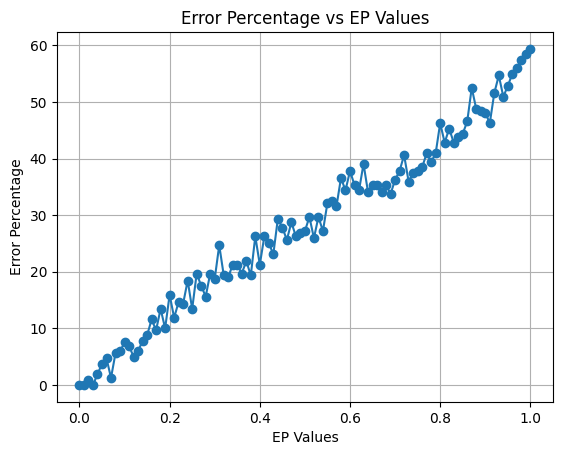

In [ ]:
# Plot the Error Percentage for each EP value
plt.plot(ep_values, error_percentagesEC, marker='o')
plt.xlabel('EP Values')
plt.ylabel('Error Percentage')
plt.title('Error Percentage vs EP Values')
plt.grid(True)
plt.show()



---

## Channel Characterizations

---
Quantum Channel(without error correction and ANG Base)

In [ ]:
ep_values = np.arange(0.00, 1.01, 0.01)
EC = False
Base = 1
length = 32
ANGerror_percentages = []
for EP in ep_values:
    SendingList = generate_random_sequence(length)
    mean = 0.0
    for i in range(10):
      ReceivedList = SendQuantumOAMChannel(SendingList, EP, Base, EC)
      ReceivedString = ''.join(str(bit) for bit in ReceivedList)
      SendingString = ''.join(str(bit) for bit in SendingList)
      error_percentage = calculate_error_percentage(ReceivedString, SendingString)
      mean += error_percentage
    ANGerror_percentages.append(mean/10)

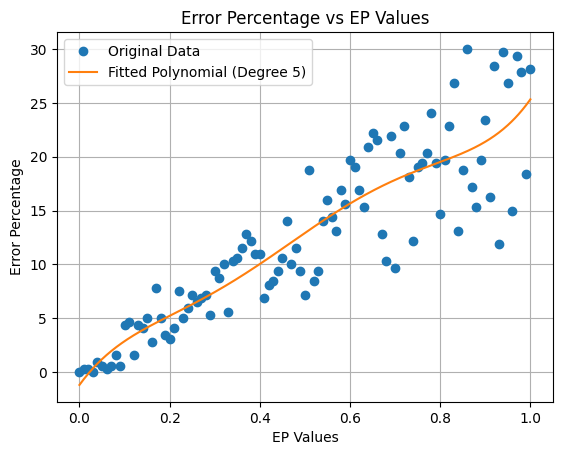

In [ ]:
# Fit a polynomial of degree 2 (quadratic) to the data
degree = 5
coefficients = np.polyfit(ep_values, ANGerror_percentages, degree)

# Create a polynomial function from the coefficients
polynomial_function = np.poly1d(coefficients)

# Generate new x values for a smooth curve
ep_values_smooth = np.linspace(min(ep_values), max(ep_values), 500)

# Use the polynomial function to get the corresponding y values
ANGerror_percentages_smooth = polynomial_function(ep_values_smooth)

# Plot the original data points
plt.plot(ep_values, ANGerror_percentages, 'o', label='Original Data')

# Plot the fitted polynomial curve
plt.plot(ep_values_smooth, ANGerror_percentages_smooth, '-', label=f'Fitted Polynomial (Degree {degree})')

plt.xlabel('EP Values')
plt.ylabel('Error Percentage')
plt.title('Error Percentage vs EP Values')
plt.legend()
plt.grid(True)
plt.show()

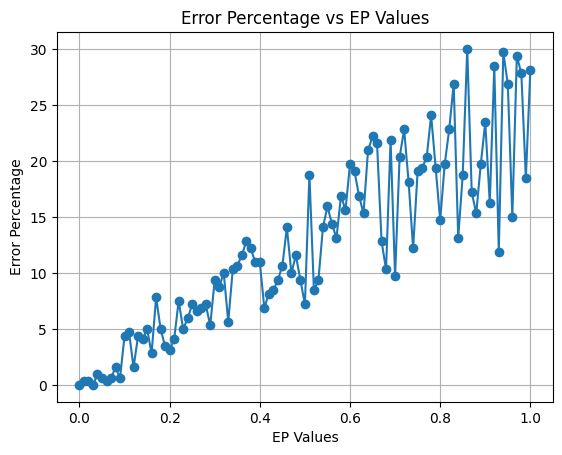

In [ ]:
# Plot the Error Percentage for each EP value
plt.plot(ep_values, ANGerror_percentages, marker='o')
plt.xlabel('EP Values')
plt.ylabel('Error Percentage')
plt.title('Error Percentage vs EP Values')
plt.grid(True)
plt.show()



---

## Channel Characterizations

---
Quantum Channel(with error correction and ANG Base)

In [ ]:
ep_values = np.arange(0.00, 1.01, 0.01)
EC = True
Base = 1
length = 32
ANGerror_percentagesEC = []
for EP in ep_values:
    SendingList = generate_random_sequence(length)
    mean = 0.0
    for i in range(10):
      ReceivedList = SendQuantumOAMChannel(SendingList, EP, Base, EC)
      ReceivedString = ''.join(str(bit) for bit in ReceivedList)
      SendingString = ''.join(str(bit) for bit in SendingList)
      error_percentage = calculate_error_percentage(ReceivedString, SendingString)
      mean += error_percentage
    ANGerror_percentagesEC.append(mean/10)

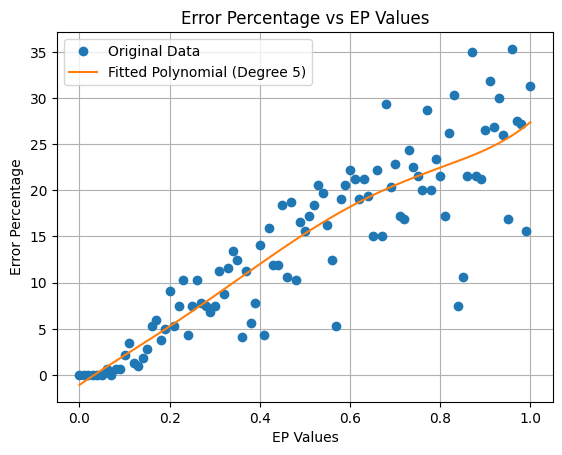

In [ ]:
# Fit a polynomial of degree 2 (quadratic) to the data
degree = 5
coefficients = np.polyfit(ep_values, ANGerror_percentagesEC, degree)

# Create a polynomial function from the coefficients
polynomial_function = np.poly1d(coefficients)

# Generate new x values for a smooth curve
ep_values_smooth = np.linspace(min(ep_values), max(ep_values), 500)

# Use the polynomial function to get the corresponding y values
ANGerror_percentages_smoothEC = polynomial_function(ep_values_smooth)

# Plot the original data points
plt.plot(ep_values, ANGerror_percentagesEC, 'o', label='Original Data')

# Plot the fitted polynomial curve
plt.plot(ep_values_smooth, ANGerror_percentages_smoothEC, '-', label=f'Fitted Polynomial (Degree {degree})')

plt.xlabel('EP Values')
plt.ylabel('Error Percentage')
plt.title('Error Percentage vs EP Values')
plt.legend()
plt.grid(True)
plt.show()

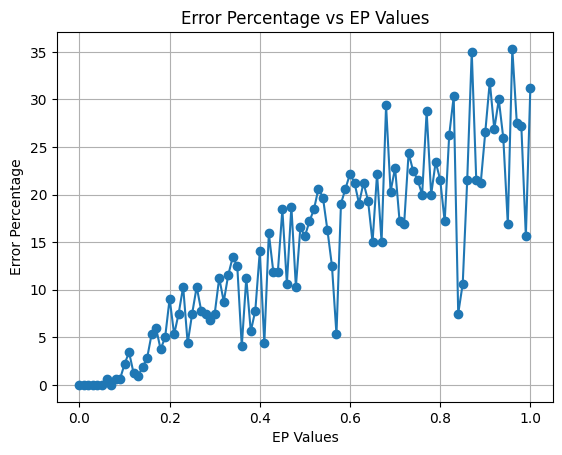

In [ ]:
# Plot the Error Percentage for each EP value
plt.plot(ep_values, ANGerror_percentagesEC, marker='o')
plt.xlabel('EP Values')
plt.ylabel('Error Percentage')
plt.title('Error Percentage vs EP Values')
plt.grid(True)
plt.show()



---

## All Quantum Channels toghether

---



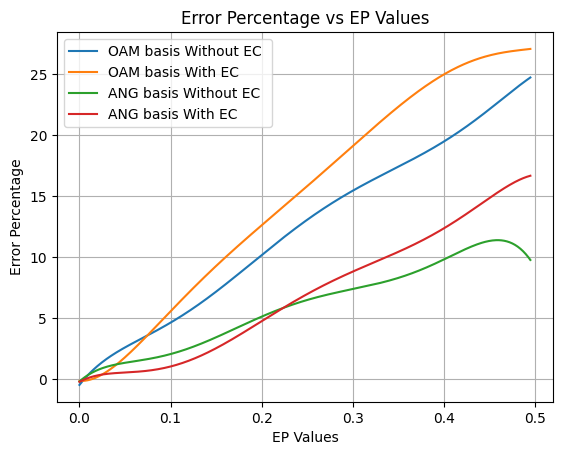

In [ ]:
# Fit a polynomial of degree 2 (quadratic) to the data
degree = 6
OAMcoefficients = np.polyfit(ep_values, error_percentages, degree)
OAMcoefficientsEC = np.polyfit(ep_values, error_percentagesEC, degree)
ANGcoefficients = np.polyfit(ep_values, ANGerror_percentages, degree)
ANGcoefficientsEC = np.polyfit(ep_values, ANGerror_percentagesEC, degree)

# Create a polynomial function from the coefficients
OAMpolynomial_function = np.poly1d(OAMcoefficients)
OAMpolynomial_functionEC = np.poly1d(OAMcoefficientsEC)
ANGpolynomial_function = np.poly1d(ANGcoefficients)
ANGpolynomial_functionEC = np.poly1d(ANGcoefficientsEC)

# Generate new x values for a smooth curve
ep_values_smooth = np.linspace(min(ep_values), max(ep_values), 500)

# Use the polynomial function to get the corresponding y values
OAMerror_percentages_smooth = OAMpolynomial_function(ep_values_smooth)
OAMerror_percentages_smoothEC = OAMpolynomial_functionEC(ep_values_smooth)
ANGerror_percentages_smooth = ANGpolynomial_function(ep_values_smooth)
ANGerror_percentages_smoothEC = ANGpolynomial_functionEC(ep_values_smooth)



# Plot the fitted polynomial curve
plt.plot(ep_values_smooth, OAMerror_percentages_smooth, '-', label=f'OAM basis Without EC ')
plt.plot(ep_values_smooth, OAMerror_percentages_smoothEC, '-', label=f'OAM basis With EC ')
plt.plot(ep_values_smooth, ANGerror_percentages_smooth, '-', label=f'ANG basis Without EC ')
plt.plot(ep_values_smooth, ANGerror_percentages_smoothEC, '-', label=f'ANG basis With EC ')


plt.xlabel('EP Values')
plt.ylabel('Error Percentage')
plt.title('Error Percentage vs EP Values')
plt.legend()
plt.grid(True)
plt.show()



---

## Channel Characterizations

---
Classical Channel(without error correction,M=4 )

In [ ]:
SNR_values = np.arange(10.00, 20.00, 0.005)
EC = False
M= 4
length = 32
Clerror_percentages = []
for SNR in SNR_values:
    SendingList = generate_random_sequence(length)
    mean = 0.0
    for i in range(10):
      ReceivedList = SendClassicalChannel(SendingList,SNR,4,EC)
      ReceivedString = ''.join(str(bit) for bit in ReceivedList)
      SendingString = ''.join(str(bit) for bit in SendingList)
      error_percentage = calculate_error_percentage(ReceivedString, SendingString)
      mean += error_percentage
    Clerror_percentages.append(mean/10)

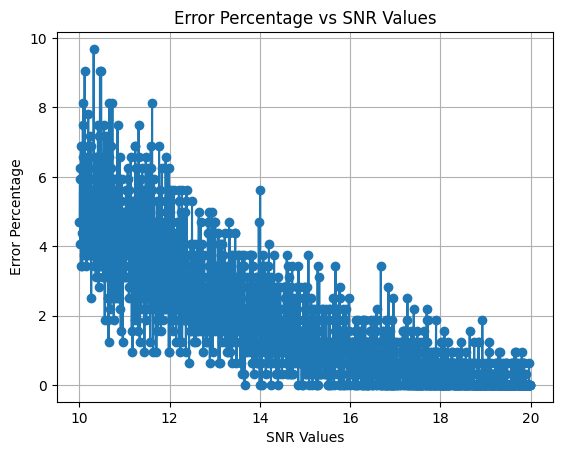

In [ ]:
# Plot the Error Percentage for each EP value
plt.plot(SNR_values, Clerror_percentages, marker='o')
plt.xlabel('SNR Values')
plt.ylabel('Error Percentage')
plt.title('Error Percentage vs SNR Values')
plt.grid(True)
plt.show()



---

## Channel Characterizations

---
Classical Channel(wit error correction,M=4 )

In [ ]:
SNR_values = np.arange(10.00, 20.00, 0.005)
EC = True
M= 4
length = 32
Clerror_percentagesEC = []
for SNR in SNR_values:
    SendingList = generate_random_sequence(length)
    mean = 0.0
    for i in range(10):
      ReceivedList = SendClassicalChannel(SendingList,SNR,4,EC)
      ReceivedString = ''.join(str(bit) for bit in ReceivedList)
      SendingString = ''.join(str(bit) for bit in SendingList)
      error_percentage = calculate_error_percentage(ReceivedString, SendingString)
      mean += error_percentage
    Clerror_percentagesEC.append(mean/10)

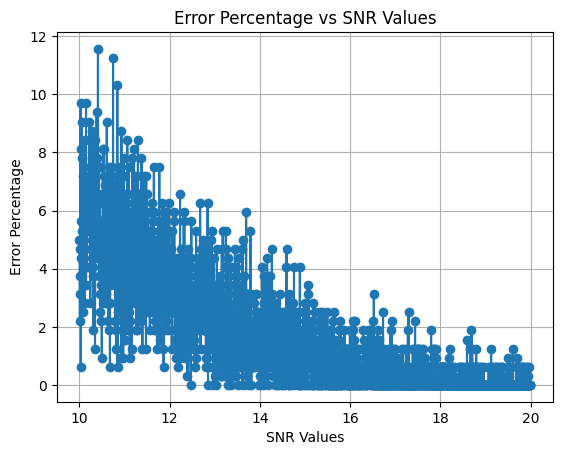

In [ ]:
# Plot the Error Percentage for each EP value
plt.plot(SNR_values, Clerror_percentagesEC, marker='o')
plt.xlabel('SNR Values')
plt.ylabel('Error Percentage')
plt.title('Error Percentage vs SNR Values')
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:757: ComplexWarning: Casting complex values to real discards the imaginary part
  posx = float(self.convert_xunits(self._x))
/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:897: ComplexWarning: Casting complex values to real discards the imaginary part
  x = float(self.convert_xunits(self._x))


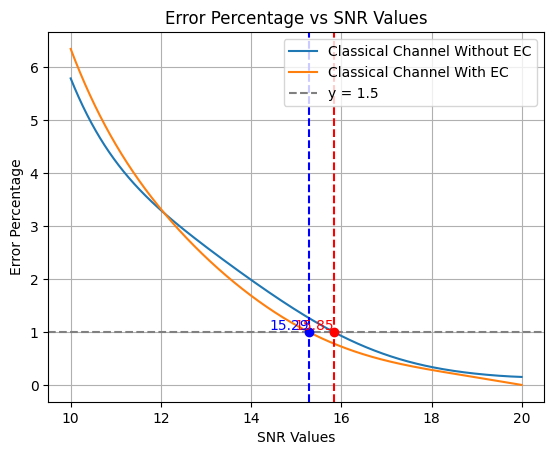

In [ ]:
# Fit a polynomial of degree 6 to the data
degree = 6
Clcoefficients = np.polyfit(SNR_values, Clerror_percentages, degree)
ClcoefficientsEC = np.polyfit(SNR_values, Clerror_percentagesEC, degree)

# Create a polynomial function from the coefficients
Clpolynomial_function = np.poly1d(Clcoefficients)
Clpolynomial_functionEC = np.poly1d(ClcoefficientsEC)

# Generate new x values for a smooth curve
SNR_values_smooth = np.linspace(min(SNR_values), max(SNR_values), 2000)

# Use the polynomial function to get the corresponding y values
Clerror_percentages_smooth = Clpolynomial_function(SNR_values_smooth)
Clerror_percentages_smoothEC = Clpolynomial_functionEC(SNR_values_smooth)

# Find x values where y = 1.5
y_target = 1.0

# Create polynomial equations for finding roots
Cl_poly_eq = np.poly1d(Clcoefficients) - y_target
Cl_poly_eqEC = np.poly1d(ClcoefficientsEC) - y_target

# Find roots
Cl_roots = np.roots(Cl_poly_eq)
Cl_rootsEC = np.roots(Cl_poly_eqEC)

# Filter the roots to be within the range of SNR_values
Cl_roots = Cl_roots[(Cl_roots >= min(SNR_values)) & (Cl_roots <= max(SNR_values))]
Cl_rootsEC = Cl_rootsEC[(Cl_rootsEC >= min(SNR_values)) & (Cl_rootsEC <= max(SNR_values))]

# Plot the fitted polynomial curves
plt.plot(SNR_values_smooth, Clerror_percentages_smooth, '-', label='Classical Channel Without EC')
plt.plot(SNR_values_smooth, Clerror_percentages_smoothEC, '-', label='Classical Channel With EC')

# Plot a horizontal line at y = 1.5
plt.axhline(y=y_target, color='gray', linestyle='--', label='y = 1.5')

# Highlight the points where y = 1.5 and add vertical lines
for root in Cl_roots:
    if root.imag == 0.0:
      plt.axvline(x=root, color='red', linestyle='--')
      plt.plot(root, y_target, 'ro')
      plt.text(root, y_target, f'{root.real:.2f}', color='red', ha='right', va='bottom')

for rootEC in Cl_rootsEC:
    if rootEC.imag == 0.0:
      plt.axvline(x=rootEC, color='blue', linestyle='--')
      plt.plot(rootEC, y_target, 'bo')
      plt.text(rootEC, y_target, f'{rootEC.real:.2f}', color='blue', ha='right', va='bottom')

# Add labels and title
plt.xlabel('SNR Values')
plt.ylabel('Error Percentage')
plt.title('Error Percentage vs SNR Values')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
ep_values = np.arange(0.00, 0.1, 0.0005)
EC = False
Base = 0
length = 32
error_percentages = []
for EP in ep_values:
    SendingList = generate_random_sequence(length)
    mean = 0.0
    for i in range(10):
      ReceivedList = SendQuantumOAMChannel(SendingList, EP, Base, EC)
      ReceivedString = ''.join(str(bit) for bit in ReceivedList)
      SendingString = ''.join(str(bit) for bit in SendingList)
      error_percentage = calculate_error_percentage(ReceivedString, SendingString)
      mean += error_percentage
    error_percentages.append(mean/10)
EC = True
Base = 0
length = 32
error_percentagesEC = []
for EP in ep_values:
    SendingList = generate_random_sequence(length)
    mean = 0.0
    for i in range(10):
      ReceivedList = SendQuantumOAMChannel(SendingList, EP, Base, EC)
      ReceivedString = ''.join(str(bit) for bit in ReceivedList)
      SendingString = ''.join(str(bit) for bit in SendingList)
      error_percentage = calculate_error_percentage(ReceivedString, SendingString)
      mean += error_percentage
    error_percentagesEC.append(mean/10)
EC = False
Base = 1
length = 32
ANGerror_percentages = []
for EP in ep_values:
    SendingList = generate_random_sequence(length)
    mean = 0.0
    for i in range(10):
      ReceivedList = SendQuantumOAMChannel(SendingList, EP, Base, EC)
      ReceivedString = ''.join(str(bit) for bit in ReceivedList)
      SendingString = ''.join(str(bit) for bit in SendingList)
      error_percentage = calculate_error_percentage(ReceivedString, SendingString)
      mean += error_percentage
    ANGerror_percentages.append(mean/10)
EC = True
Base = 1
length = 32
ANGerror_percentagesEC = []
for EP in ep_values:
    SendingList = generate_random_sequence(length)
    mean = 0.0
    for i in range(10):
      ReceivedList = SendQuantumOAMChannel(SendingList, EP, Base, EC)
      ReceivedString = ''.join(str(bit) for bit in ReceivedList)
      SendingString = ''.join(str(bit) for bit in SendingList)
      error_percentage = calculate_error_percentage(ReceivedString, SendingString)
      mean += error_percentage
    ANGerror_percentagesEC.append(mean/10)

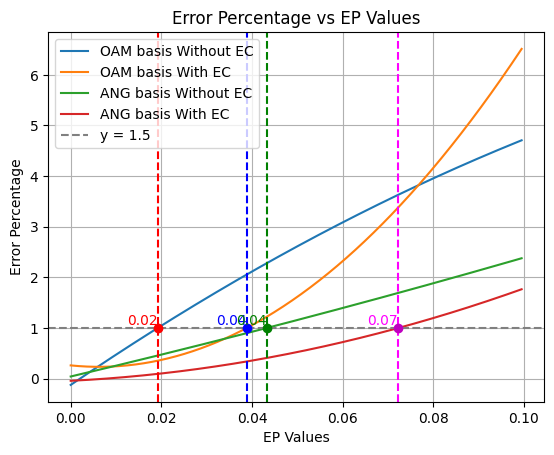

In [ ]:
# Fit a polynomial of degree 6 to the data
degree = 2
OAMcoefficients = np.polyfit(ep_values, error_percentages, degree)
OAMcoefficientsEC = np.polyfit(ep_values, error_percentagesEC, degree)
ANGcoefficients = np.polyfit(ep_values, ANGerror_percentages, degree)
ANGcoefficientsEC = np.polyfit(ep_values, ANGerror_percentagesEC, degree)

# Create a polynomial function from the coefficients
OAMpolynomial_function = np.poly1d(OAMcoefficients)
OAMpolynomial_functionEC = np.poly1d(OAMcoefficientsEC)
ANGpolynomial_function = np.poly1d(ANGcoefficients)
ANGpolynomial_functionEC = np.poly1d(ANGcoefficientsEC)

# Generate new x values for a smooth curve
ep_values_smooth = np.linspace(min(ep_values), max(ep_values), 500)

# Use the polynomial function to get the corresponding y values
OAMerror_percentages_smooth = OAMpolynomial_function(ep_values_smooth)
OAMerror_percentages_smoothEC = OAMpolynomial_functionEC(ep_values_smooth)
ANGerror_percentages_smooth = ANGpolynomial_function(ep_values_smooth)
ANGerror_percentages_smoothEC = ANGpolynomial_functionEC(ep_values_smooth)

# Find x values where y = 1.5
y_target = 1.0

# Create polynomial equations for finding roots
OAM_poly_eq = np.poly1d(OAMcoefficients) - y_target
OAM_poly_eqEC = np.poly1d(OAMcoefficientsEC) - y_target
ANG_poly_eq = np.poly1d(ANGcoefficients) - y_target
ANG_poly_eqEC = np.poly1d(ANGcoefficientsEC) - y_target

# Find roots
OAM_roots = np.roots(OAM_poly_eq)
OAM_rootsEC = np.roots(OAM_poly_eqEC)
ANG_roots = np.roots(ANG_poly_eq)
ANG_rootsEC = np.roots(ANG_poly_eqEC)

# Filter the roots to be within the range of ep_values
OAM_roots = OAM_roots[(OAM_roots >= min(ep_values)) & (OAM_roots <= max(ep_values))]
OAM_rootsEC = OAM_rootsEC[(OAM_rootsEC >= min(ep_values)) & (OAM_rootsEC <= max(ep_values))]
ANG_roots = ANG_roots[(ANG_roots >= min(ep_values)) & (ANG_roots <= max(ep_values))]
ANG_rootsEC = ANG_rootsEC[(ANG_rootsEC >= min(ep_values)) & (ANG_rootsEC <= max(ep_values))]

# Plot the fitted polynomial curves
plt.plot(ep_values_smooth, OAMerror_percentages_smooth, '-', label='OAM basis Without EC')
plt.plot(ep_values_smooth, OAMerror_percentages_smoothEC, '-', label='OAM basis With EC')
plt.plot(ep_values_smooth, ANGerror_percentages_smooth, '-', label='ANG basis Without EC')
plt.plot(ep_values_smooth, ANGerror_percentages_smoothEC, '-', label='ANG basis With EC')

# Plot a horizontal line at y = 1.5
plt.axhline(y=y_target, color='gray', linestyle='--', label='y = 1.5')

# Highlight the points where y = 1.5 and add vertical lines
for root in OAM_roots:
    if root.imag == 0.0:
      plt.axvline(x=root, color='red', linestyle='--')
      plt.plot(root, y_target, 'ro')
      plt.text(root, y_target, f'{root.real:.2f}', color='red', ha='right', va='bottom')

for rootEC in OAM_rootsEC:
    if rootEC.imag == 0.0:
      plt.axvline(x=rootEC, color='blue', linestyle='--')
      plt.plot(rootEC, y_target, 'bo')
      plt.text(rootEC, y_target, f'{rootEC.real:.2f}', color='blue', ha='right', va='bottom')

for root in ANG_roots:
    if root.imag == 0.0:
      plt.axvline(x=root, color='green', linestyle='--')
      plt.plot(root, y_target, 'go')
      plt.text(root, y_target, f'{root.real:.2f}', color='green', ha='right', va='bottom')

for rootEC in ANG_rootsEC:
    if rootEC.imag == 0.0:
      plt.axvline(x=rootEC, color='magenta', linestyle='--')
      plt.plot(rootEC, y_target, 'mo')
      plt.text(rootEC, y_target, f'{rootEC.real:.2f}', color='magenta', ha='right', va='bottom')

# Add labels and title
plt.xlabel('EP Values')
plt.ylabel('Error Percentage')
plt.title('Error Percentage vs EP Values')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from scipy.stats import norm

def calculate_sample_size(confidence_level, error_margin, Pe):
    # Convert confidence level to a Z-score
    alpha = 1 - confidence_level
    z_score = norm.ppf(1 - alpha / 2)

    # Calculate the sample size
    n = (z_score ** 2 * Pe * (1 - Pe)) / (error_margin ** 2)

    return n

# Example usage
confidence_level = 0.90  # 90% confidence level
error_margin = 0.05     # 0.2% error margin
Pe = 0.2573 # Probability of error

required_n = calculate_sample_size(confidence_level, error_margin, Pe)
print(f'Required number of simulations: {required_n:.0f}')

Required number of simulations: 207
